Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


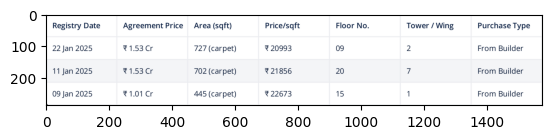

OC Output:

Registry Date Agreement Price Area (sqft) Price/sqft Floor No. Tower / Wing Purchase Type
22 Jan 2025 21.53 Cr 727 (carpet) = 20993 09 2 From Builder
11 Jan 2025 21.53 Cr 702 (carpet) 21856 20 7 From Builder
09 Jan 2025 21.01 Cr 445 (carpet) 2 22673 15 1 From Builder

  Registry Date Agreement Price Area (sq.ft.) Price/sq.ft. Floor No.  \
0   22 Jan 2025        ₹21.53Cr  727 (carpet)       ₹20993        09   
1   11 Jan 2025        ₹21.53Cr  702 (carpet)       ₹21856        20   
2   09 Jan 2025        ₹21.01Cr  445 (carpet)       ₹22673        15   

  Tower / Wing Purchase Type  
0            2  From Builder  
1            7  From Builder  
2            1  From Builder  


In [18]:
!pip install pytesseract
!apt install tesseract-ocr
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re


image_path = list(uploaded.keys())[0]
img = cv2.imread('/content/In Chandak Highscape City, Chembur, Mumbai-page_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

custom_config = r'--oem 3 --psm 6'
raw_text = pytesseract.image_to_string(thresh, config=custom_config)
print("OC Output:\n")
print(raw_text)
lines = [line.strip() for line in raw_text.split('\n')]
rows =[]
date_pattern = re.compile(r"\d{2} \w{3} \d{4}")
for line in lines:
  if date_pattern.search(line):
    rows.append(line)
columns = ['Registry Date', 'Agreement Price', 'Area (sq.ft.)', 'Price/sq.ft.', 'Floor No.', 'Tower / Wing', 'Purchase Type']
structured_data = []

for line in rows:

    line = line.replace('%', '₹').replace('Rs.', '₹').replace('=', '₹').replace('`', '₹')
    line = re.sub(r'\b2\b(?= ?\d{4,6})', '₹', line)


    date = re.search(r'\d{2} \w{3} \d{4}', line)
    price = re.search(r'\d{1,2}\.?\d{1,2} ?Cr', line)
    area = re.search(r'\d{3,4} ?\(carpet\)', line)
    rate = '-'
    area_match = re.search(r'\d{3,4} ?\(carpet\)', line)
    if area_match:
        after_area = line[area_match.end():]
        rate_match = re.search(r'(?:[₹=] ?)?\d{4,6}', after_area)
        if rate_match:
            rate = rate_match.group().replace('₹', '').replace('=', '').strip()

    purchase = re.search(r'From Builder', line, re.IGNORECASE)


    floor = tower = '-'
    if purchase:
        before_purchase = line[:purchase.start()].strip()
        numbers = re.findall(r'\b\d{1,2}\b', before_purchase)
        if len(numbers) >= 2:
            floor = numbers[-2]
            tower = numbers[-1]

    structured_data.append([
        date.group() if date else '-',
        price.group().replace(' ', '') if price else '-',
        area.group() if area else '-',
        rate if rate != '-' else '-',
        floor,
        tower,
        purchase.group() if purchase else '-'
    ])


df = pd.DataFrame(structured_data, columns=columns)

df['Agreement Price'] = df['Agreement Price'].apply(lambda x: f'₹{x}' if x != '-' else x)
df['Price/sq.ft.'] = df['Price/sq.ft.'].apply(lambda x: f'₹{x}' if x != '-' else x)

print(df)